In [51]:
import re
import srt 
import glob
import pandas as pd
import os
import numpy as np
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import spacy

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split,
    HalvingRandomSearchCV
)
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix,
    f1_score, roc_auc_score,
    classification_report, make_scorer
)

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import NearMiss 

from catboost import CatBoostClassifier, CatBoostRegressor, Pool

from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse

In [52]:
DATA_PATH = 'English_level/data_all'

HTML = r'<.*?>'
TAG = r'{.*?}'
COMMENTS = r'[\(\[][A-Z ]+[\)\]]'
LETTERS = r'[^a-zA-Z\'.,!? ]'
SPACES = r'([ ])\1+'
DOTS = r'[\.]+'

YEAR_SRT = r'(\(\d{4}\))'
CLEAN_TEXT = r'[^a-z\s\|]'

def clean_subs(subs):
    txt = re.sub(HTML, ' ', subs) #html тэги меняем на пробел
    txt = re.sub(TAG, ' ', txt) #тэги меняем на пробел
    txt = re.sub(COMMENTS, ' ', txt) #комменты меняем на пробел
    txt = re.sub(LETTERS, ' ', txt) #все что не буквы меняем на пробел
    txt = re.sub(SPACES, r'\1', txt) #повторяющиеся пробелы меняем на один пробел
    txt = re.sub(DOTS, r'.', txt)  #многоточие меняем на точку
    return txt

### Предобработка данных

Читаем файлы, создаем переменные:
dframes - обьект, связывающий имена файлов с датафреймами субтитров.
films - датафрейм с именами фильмов и классификацией

In [53]:
dframes = {}
files = glob.glob(f'{DATA_PATH}/Subtitles_all/*.srt')

for filename in files:
    try:
        with open(filename) as f:
            #удаляем все что не ascii символы   
            subtitle_generator = srt.parse(f.read().encode('ascii', 'ignore').decode())
            #удаляем первый и последний субтитр (обычно это реклама)
            df = pd.DataFrame(list([[item.start, item.end, item.content] for item in subtitle_generator][1:-1]), columns=['start','end','content'])
            df['content'] = df['content'].apply(clean_subs)
            df['content'] = df['content'].str.strip().replace('', np.nan).str.lower()
            df.dropna(subset=['content'], inplace=True)
            df.reset_index(drop=True, inplace=True)

            dframes[os.path.basename(f.name)] = df

    except srt.SRTParseError as e:
        print(filename, e)
        
films = pd.DataFrame([n for n in dframes], columns=['name'])
films['year'] = films['name'].str.extract(YEAR_SRT, flags=0)
films['parsed_name'] = films.apply(lambda x: x['name'].replace(str(x['year']), '').replace('_', ' ').replace('.srt', ''), axis=1)

labels = pd.read_csv(f'{DATA_PATH}/labels_all.csv')

In [54]:
for index in labels.index:
    item = labels.loc[index, 'Movie']
    found = process.extractOne(item, films['parsed_name'])
    labels.loc[index, ['found', 'probability', 'index']] = found

labels['index'] = labels['index'].astype(int)
films = labels.set_index('index').join(films)

def getClass(title):
    if title.find('C1') >= 0:
        return 'C1'
    if title.find('B2') >= 0:
        return 'B2'
    if title.find('B1') >= 0:
        return 'B1'
    if title.find('A2+') >= 0:
        return 'A2/A2+'
    
films['Level'] = films['Level'].apply(getClass)
films = films[['Movie', 'Level', 'name']]
films.columns = ['movie', 'level', 'name']
display(films)

,movie,level,name
index,,,
37,Forrest Gump,B1,Forrest_Gump(1994).srt
36,Finding Nemo\n,A2/A2+,Finding_Nemo(2003).srt
21,Cast away\n,A2/A2+,Cast_away(2000).srt
91,The invisible man (2020)\n,A2/A2+,The_invisible_man(2020).srt
8,Back to the future\n,A2/A2+,Back_to_the_future(1985).srt
...,...,...,...
48,Klaus,C1,Klaus(2019).srt
67,Ocean’s Eleven,C1,Oceans_Eleven(2001).srt
68,Ocean’s Twelve,C1,Oceans_Twelve(2004).srt


Создаем вспомогательные функции для лемматизации, обучения модели и построения матрицы.

In [55]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def lemmatize(text):    
    doc = nlp(text)
    
    lemmatized_text = ' '.join(['' if token.is_stop else token.lemma_ for token in doc])
    lemmatized_text = re.sub(CLEAN_TEXT, ' ', lemmatized_text)
    lemmatized_text = re.sub(SPACES, r'\1', lemmatized_text)

    return lemmatized_text.split('|')

In [56]:
def search_best_estimator(pipeline, param_grid, x, y):
    hrs = HalvingRandomSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        scoring='f1_weighted',
        cv=3,
        n_candidates="exhaust",
        factor=5,
        n_jobs=-1,
        verbose=2
    )
    _ = hrs.fit(x, y)
    return hrs.best_estimator_

In [57]:
def plot_confusion_matrix(y_test, y_preds, model):
    fig, ax = plt.subplots(figsize=(8,5))
    cm = confusion_matrix(y_test, y_preds)
    cmp = ConfusionMatrixDisplay(cm, display_labels = model.classes_ )
    cmp.plot(ax=ax)
    plt.show()

In [58]:
for index in films.index:
    name = films.loc[index, 'name']
    text = '|'.join(dframes[name]['content'])
    result = lemmatize(text)
    dframes[name]['content'] = pd.Series(result)

Поскольку данных мало увеличим их количество путем разбиения текстов на части, каждой части назначен класс оригинального фильма

In [59]:
content = []
titles = []
mean = []
median = []
split_factors = 16

for name in dframes:
    df_content = dframes[name]['content']
    size = df_content.size // split_factors
    for i in range(split_factors):
        titles.append(name)
        dframes[name]['content'].str.split(' ').apply(lambda x: len(x)) / (dframes[name].end - dframes[name].start).dt.total_seconds()
        df_part = dframes[name][i * size : (i+1) * size]
        df_div = df_part['content'].str.split(' ').apply(lambda x: len(x)) / (df_part['end'] - df_part['start']).dt.total_seconds()
        mean.append(df_div[(df_div > 0.1) & (df_div < 5)].mean())
        median.append(df_div[(df_div > 0.1) & (df_div < 5)].median())
        content.append(''.join(df_content[i * size : (i+1) * size]))

In [60]:
df_films_splitted = films.merge(pd.DataFrame(data={'name':titles, 'content':content, 'mean': mean, 'median': median}), on='name')
df_films_splitted = df_films_splitted[['level', 'content', 'mean', 'median']].reset_index(drop=True)

In [61]:
df_films_splitted['level'].value_counts()

B1        640
B2        608
A2/A2+    400
C1        128
Name: level, dtype: int64

In [133]:
words = pd.read_csv(f'Parsed/words.csv', index_col=[0])

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 24
max_resources_: 1776
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 74
n_resources: 24
Fitting 3 folds for each of 74 candidates, totalling 222 fits
----------
iter: 1
n_candidates: 15
n_resources: 120
Fitting 3 folds for each of 15 candidates, totalling 45 fits
----------
iter: 2
n_candidates: 3
n_resources: 600
Fitting 3 folds for each of 3 candidates, totalling 9 fits


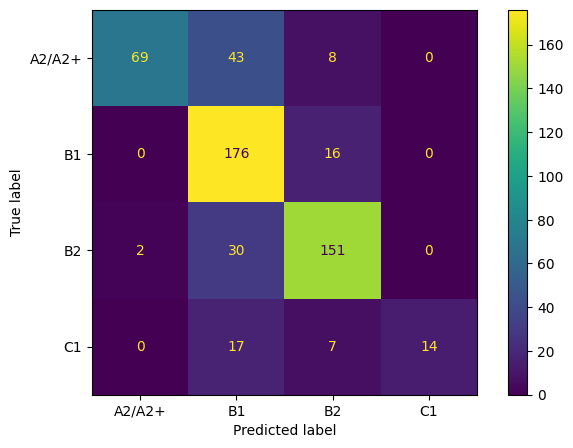

In [158]:
x, y = df_films_splitted['content'].tolist(), df_films_splitted['level'].tolist()

# vocabulary=words['name'].str.strip().str.lower().unique()
pipeline = Pipeline(
    steps = [("tfidf", TfidfVectorizer() ),("base", RandomForestClassifier() )]
)

param_grid = {
    "tfidf__min_df": [i for i in range(0,20,5)],
    "tfidf__max_df": [i for i in range(50,100,10)],
    "base__n_estimators": [i for i in range(150,250,50)],
    "base__max_depth": [i for i in range(25,35,5)],
    "base__min_samples_split":[i for i in range(6,10,2)],
    "base__min_samples_leaf": [2],
}

estimator = search_best_estimator(pipeline, param_grid, x, y)

X_train, X_test, y_train, y_test = train_test_split(
    x, y, random_state=42, test_size=0.3, stratify=y
)
estimator.fit(X_train, y_train)
y_preds = estimator.predict(X_test)
plot_confusion_matrix(y_test, y_preds, estimator)

In [173]:
report = classification_report(y_test, y_preds, target_names=[
    'C1',
    'B2',
    'B1',
    'A2/A2+'
])
print(report)

              precision    recall  f1-score   support

          C1       0.97      0.57      0.72       120
          B2       0.66      0.92      0.77       192
          B1       0.83      0.83      0.83       183
      A2/A2+       1.00      0.37      0.54        38

    accuracy                           0.77       533
   macro avg       0.87      0.67      0.71       533
weighted avg       0.81      0.77      0.76       533



In [172]:
print( f' Model F1-score: {f1_score(y_test, y_preds, average="weighted")}' )

 Model F1-score: 0.7619889803932388


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 24
max_resources_: 512
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 8
n_resources: 24
Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\Kirill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=21. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 2
n_resources: 120
Fitting 3 folds for each of 2 candidates, totalling 6 fits


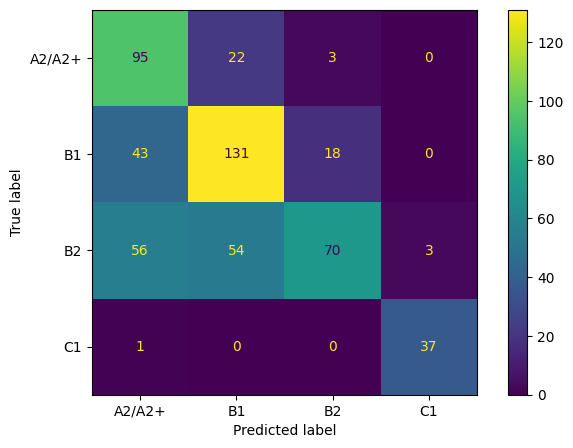

In [159]:
# vocabulary=words['name'].unique()
# 
vectorizer = TfidfVectorizer(**estimator[0].get_params(deep=True))
vectorizer.fit(x)

vect_x = vectorizer.transform(x)

nm = NearMiss()
X_res, Y_res = nm.fit_resample(vect_x, y)
pipeline2 = Pipeline( steps = [("base", RandomForestClassifier() )]  )
# CatBoostClassifier(task_type='GPU')
param_grid2 = {
    "base__n_estimators": [i for i in range(150,250,50)],
    "base__max_depth": [i for i in range(25,35,5)],
    "base__min_samples_split":[i for i in range(6,10,2)],
    "base__min_samples_leaf": [2],
}
estimator2 = search_best_estimator(pipeline2, param_grid2, X_res, Y_res)
X_train, X_test, y_train, y_test = train_test_split(
    vect_x, y, random_state=42, test_size=0.3, stratify=y
)
estimator2.fit(X_res, Y_res)
y_preds2 = estimator2.predict(X_test)
plot_confusion_matrix(y_test, y_preds2, estimator2)


In [167]:
report = classification_report(y_test, y_preds2, target_names=[
    'C1',
    'B2',
    'B1',
    'A2/A2+'
])
print(report)

              precision    recall  f1-score   support

          C1       0.59      0.76      0.67       120
          B2       0.59      0.73      0.65       192
          B1       0.71      0.38      0.50       183
      A2/A2+       0.88      0.97      0.93        38

    accuracy                           0.64       533
   macro avg       0.69      0.71      0.69       533
weighted avg       0.65      0.64      0.62       533



n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 24
max_resources_: 512
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 8
n_resources: 24
Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\Kirill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=21. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 2
n_resources: 120
Fitting 3 folds for each of 2 candidates, totalling 6 fits


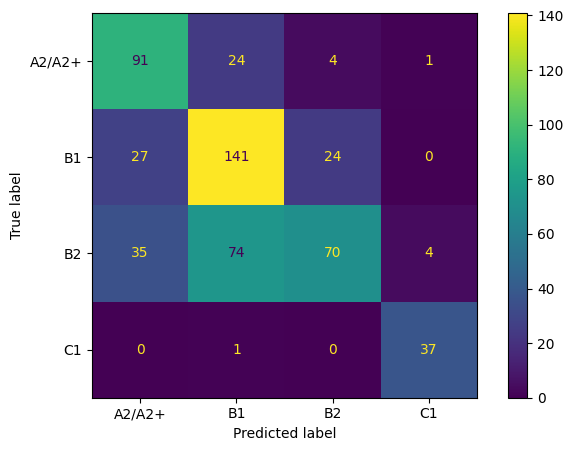

In [163]:
# vect_x = vectorizer.transform(x)
# vect_x = sparse.hstack((sparse.csr_matrix(df_films_splitted[['mean','median']].values), vect_x))

# nm = NearMiss()
# X_res, Y_res = nm.fit_resample(vect_x, y)
# pipeline2 = Pipeline( steps = [("base", RandomForestClassifier() )]  )

# param_grid2 = {
#     "base__n_estimators": [i for i in range(150,250,50)],
#     "base__max_depth": [i for i in range(25,35,5)],
#     "base__min_samples_split":[i for i in range(6,10,2)],
#     "base__min_samples_leaf": [2],
# }
# estimator2 = search_best_estimator(pipeline2, param_grid2, X_res, Y_res)
# X_train, X_test, y_train, y_test = train_test_split(
#     vect_x, y, random_state=42, test_size=0.3, stratify=y
# )
# estimator2.fit(X_res, Y_res)
# y_preds2 = estimator2.predict(X_test)
# plot_confusion_matrix(y_test, y_preds2, estimator2)

In [113]:
# feature_importances = pd.DataFrame(estimator2[0].feature_importances_, index=vectorizer.get_feature_names() + ['mean','median'], columns=['importances']).sort_values(by='importances', ascending=False)

c:\Users\Kirill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 2
min_resources_: 24
max_resources_: 512
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 1
n_resources: 24
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\Kirill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=21. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0:	learn: 1.3373171	total: 36.7ms	remaining: 3.63s
1:	learn: 1.2986205	total: 69.8ms	remaining: 3.42s
2:	learn: 1.2650577	total: 104ms	remaining: 3.37s
3:	learn: 1.2288294	total: 139ms	remaining: 3.33s
4:	learn: 1.2030685	total: 174ms	remaining: 3.3s
5:	learn: 1.1768889	total: 207ms	remaining: 3.24s
6:	learn: 1.1562302	total: 241ms	remaining: 3.2s
7:	learn: 1.1343070	total: 281ms	remaining: 3.23s
8:	learn: 1.1133518	total: 317ms	remaining: 3.2s
9:	learn: 1.0931194	total: 351ms	remaining: 3.15s
10:	learn: 1.0732369	total: 388ms	remaining: 3.13s
11:	learn: 1.0552664	total: 424ms	remaining: 3.11s
12:	learn: 1.0404139	total: 459ms	remaining: 3.07s
13:	learn: 1.0266693	total: 494ms	remaining: 3.03s
14:	learn: 1.0133967	total: 529ms	remaining: 3s
15:	learn: 1.0003693	total: 563ms	remaining: 2.96s
16:	learn: 0.9870389	total: 596ms	remaining: 2.91s
17:	learn: 0.9754310	total: 630ms	remaining: 2.87s
18:	learn: 0.9638335	total: 666ms	remaining: 2.84s
19:	learn: 0.9519652	total: 699ms	remaining: 

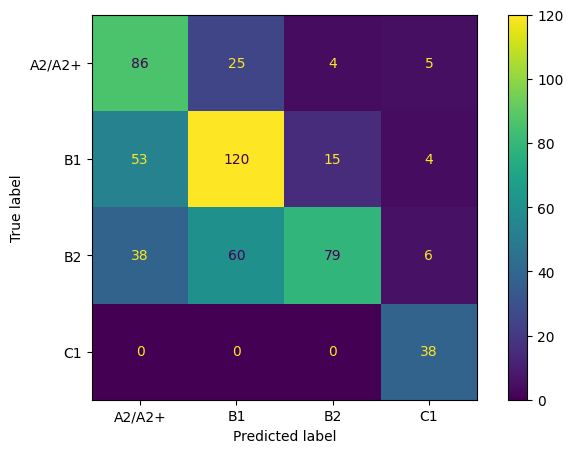

In [128]:
# vect_x = vectorizer.transform(x)
# vect_x = sparse.hstack((sparse.csr_matrix(df_films_splitted[['mean','median']].values), vect_x))

# nm = NearMiss()
# X_res, Y_res = nm.fit_resample(vect_x, y)
# pipeline2 = Pipeline( steps = [("base", CatBoostClassifier(iterations=100, learning_rate=0.1, depth=10, task_type='GPU') )]  )
# # CatBoostClassifier(task_type='GPU')
# param_grid2 = {
#     # "base__n_estimators": [i for i in range(200,300,50)],
#     # "base__max_depth": [i for i in range(25,35,5)],
#     # "base__min_samples_split": [i for i in range(8,12,2)],
# }
# estimator2 = search_best_estimator(pipeline2, param_grid2, X_res, Y_res)
# X_train, X_test, y_train, y_test = train_test_split(
#     vect_x, y, random_state=42, test_size=0.3, stratify=y
# )
# estimator2.fit(X_res, Y_res)
# y_preds2 = estimator2.predict(X_test)
# plot_confusion_matrix(y_test, y_preds2, estimator2)

In [72]:
# https://stackoverflow.com/a/69678207
# https://habr.com/ru/post/702626/